# Problem 2: Optimizing Encoders with PyStorm

In [2]:
# basic imports for working with matrices and plotting
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage # for processing firing-rate measurements

# for building and running SNN simulations
import nengo
import nengo_brainstorm

As stated in the attached problem set outline, this problem will introduce you to PyStorm, a Python package that directly exposes Braindrop's high-level hardware constructs. In particular, it provides finer control over encoders through _tap points_, which Nengo-Brainstorm doesn't expose. Basic familiarity with PyStorm's network objects is assumed (see first 2 pages of __braindrop_pystorm_documentation.pdf__). 

First, we will motivate encoder optimization with a simple Nengo simulation, demonstrating the consequences of poorly distributed encoders. Then, you will code functions to create 2D tap-point matrices, estimate the encoding vectors they produce, and test them by decoding $f(\mathbf{x}) = x_1x_2$. Finally, you will code the algorithm for creating 3+ dimensional tap-point matrices, testing them on the more general class of functions $f(\mathbf{x}) = \Pi_i^D x_i$.

## 2.1 The Importance of Mixing Dimensions
Braindrop's encoders are set by defining _anchor encoders_ at tap-points, a subset of synaptic lowpass filters that feed the diffuser. We rely on the diffuser to mix the stimulus' different dimensions when computing nonlinear functions of multidimensional variables. To see this, you will first build a toy model in Nengo to compute $f(\mathbf{x}) = x_1 x_2$ with 2 ensembles: one that uses the default encoders, which are drawn from a uniform hyperspherical distribution, and another that uses encoders focused around the standard basis vectors $\pm \mathbf{e}_1 = [\pm 1, 0]^\intercal$ and $\pm \mathbf{e}_2 = [0, \pm 1]^\intercal$.

### 2.1.1 Standard basis-vector encoders
To compare an ensemble with uniformly distributed encoders to an ensemble with standard basis encoders, complete the function `poor_2d_encoders()` below to generate $N$ random unit vectors within an angle $\pm \theta$ from $\pm \mathbf{e}_1$ or $\pm \mathbf{e}_2$.
 - Call this function with N = 128 and $\theta=5°$ and scatter plot the returned encoders.
 - Call `ax.set_aspect('equal')` to use a 1:1 aspect-ratio when plotting.

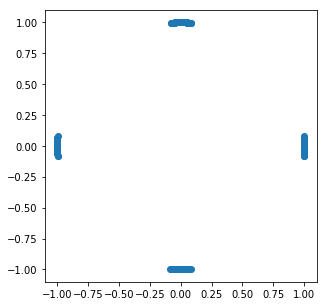

In [3]:
def poor_2d_encoders(N, theta):
    """
    Returns random 2d unit vectors within an angle theta 
    from the standard basis vectors
    
    Parameters:
    -----------
    N: int
        Number of encoding vectors to generate
    theta: float
        Maximum angle (in degrees) between a vector and the standard basis
    
    Returns:
    --------
    encs: numpy matrix
        N-by-2 matrix of encoding vectors
    """
    # your code here
    rdims = np.random.randint(2, size=N)
    rsign = 2*np.random.randint(2, size=N)-1
    max_ang = 2*np.pi*theta/360
    rangles = max_ang*(2*np.random.rand(N)-1)

    encs = np.array([(sgn*(d*np.cos(a) + (1-d)*np.sin(a)), sgn*(d*np.sin(a) + (1-d)*np.cos(a))) 
                     for a, d, sgn in zip(rangles, rdims, rsign)])

    return encs

N = 128
theta = 5
bad_encs = poor_2d_encoders(N, theta)
plt.figure(figsize=(5,5)); ax = plt.gca()
plt.scatter(bad_encs[:,0], bad_encs[:,1])
plt.ylim([-1.1, 1.1])
plt.xlim([-1.1, 1.1])
ax.set_aspect('equal')

### 2.1.2 Testing encoders with Nengo
Now build two 2D ensembles in Nengo, each with $N=128$ neurons, one with the default encoders, and another with the encoders you generated in 2.1.1. To do so, set `encoders=encs` in the `nengo.Ensemble()` constructor. Use the 2D stimulus $\mathbf{x}(t) = \frac{1}{\sqrt{2}}[\cos(2\pi t), \sin(2\pi t)]$ and run the simulation for $T = 2$. Note that we scale our stimulus by $1/\sqrt{2}$ to keep $||\mathbf{x}(t)|| \leq 1 = ||\mathbf{e}_i||$ (i.e., so that the projection of the stimulus on the encoders is always less than 1). 

In addition to driving these two ensembles, create two output nodes with `size_in=1` to receive their decoded spike-rates. Finally, create an additional output node with `size_in=1` to compute the correct signal $f(\mathbf{x}(t)) = x_1(t)x_2(t)$. Connect the input node directly this node, applying the desired function on its connection. Create probes to measure the output nodes of both ensembles, as well as the output node with the correct signal, filtering each with a time-constant given in `tau_probe`.

Building finished in 0:00:01.                                                                                                               
Simulating finished in 0:00:02.                                                                                                             
RMSE from Ensemble with Uniformly Distributed Encoders: 0.024251433334026
RMSE from Ensemble with Poorly Distributed Encoders: 0.11879494409812756


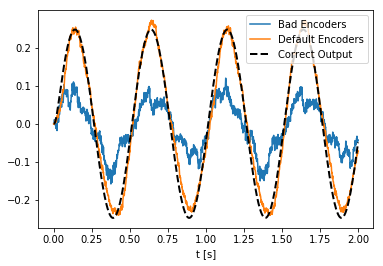

In [3]:
N = 128
dims = 2
tau_probe = 0.01

# your code here
model = nengo.Network()

with model:
    inp_node = nengo.Node(lambda t: (np.cos(2*np.pi*t)/np.sqrt(2), np.sin(2*np.pi*t)/np.sqrt(2)))
    
    ensA = nengo.Ensemble(N, dimensions=dims, encoders=bad_encs)
    ensB = nengo.Ensemble(N, dimensions=dims)
    
    outA_node = nengo.Node(size_in=1) #nengo.Ensemble(N, dimensions=1, neuron_type=nengo.Direct())
    outB_node = nengo.Node(size_in=1)
    fout_node = nengo.Node(size_in=1)
    
    nengo.Connection(inp_node, ensA)
    nengo.Connection(ensA, outA_node, function=lambda x: x[0]*x[1])
    nengo.Connection(inp_node, ensB)
    nengo.Connection(ensB, outB_node, function=lambda x: x[0]*x[1])
    nengo.Connection(inp_node, fout_node, function=lambda x: x[0]*x[1])
    
    inp_probe = nengo.Probe(inp_node)
    outA_probe = nengo.Probe(outA_node, synapse=tau_probe)
    outB_probe = nengo.Probe(outB_node, synapse=tau_probe)
    fout_probe = nengo.Probe(fout_node, synapse=tau_probe)

sim = nengo.Simulator(model)
sim.run(2)

plt.figure()
plt.plot(sim.trange(), sim.data[outA_probe], label='Bad Encoders')
plt.plot(sim.trange(), sim.data[outB_probe], label='Default Encoders')
plt.plot(sim.trange(), sim.data[fout_probe], '--k', label='Correct Output', lw=2)
plt.legend()
plt.xlabel(r't [s]')

print("RMSE from Ensemble with Uniformly Distributed Encoders:", 
      np.sqrt(np.mean((sim.data[outB_probe] - sim.data[fout_probe])**2)))
print("RMSE from Ensemble with Poorly Distributed Encoders:", 
      np.sqrt(np.mean((sim.data[outA_probe] - sim.data[fout_probe])**2)))

## Working with PyStorm
Several parts of the following sections will require you to run code on Braindrop. To do this, follow the procedure for uploading your notebook to the ng-amygdala server. For your convenience, we've included the connection guide with this assignment (__remote_connection.pdf__).

*** NOTE ***

Below we've provided a cell for resetting the chip's connection to the server. In most cases, this code will be unnecessary. However, sometimes when the initial handshake occurs (during the `HAL()` call in the tutorial code below), the USB connection fails and the Python call quickly raises the error messeage `Comm failed to init`. If this happens, run this cell below to reset the connection and try again. This may take a few tries for it to reconnect.


In [4]:
!sudo /home/ee207student/usbreset.sh # reset the USB connection, which sometimes dies.
# if Comm below is repeatedly & quickly failing to init, you can run this cell.

0000:08:00.0
tee: /sys/bus/pci/drivers/xhci_hcd/bind: No such device
Resetting devices from /sys/bus/pci/drivers/uhci_hcd...
/home/ee207student/usbreset.sh: line 20: echo: write error: No such device
/home/ee207student/usbreset.sh: line 21: echo: write error: No such device
Resetting devices from /sys/bus/pci/drivers/xhci_hcd...


*** END NOTE ***

In [5]:
############################################################################
# Importing essential PyStorm libraries

# HAL, or Hardware Abstraction Layer, must be imported and initialized
from pystorm.hal import HAL
HAL = HAL()

# data_utils contains a useful function for binning spikes and estimating spike rates
from pystorm.hal import data_utils

# RunControl objects are responsible for executing command sequences on the chip, such as initiating
# tuning curve measurements
from pystorm.hal.run_control import RunControl

# Graph objects represent properties of your network
# so that HAL can allocate resources for them on the chip
from pystorm.hal.neuromorph import graph 

To get you started, we've copied some functions from the attached PyStorm walkthrough.
 - `plot_tap_matrix()` will plot tap-points for each dimension. For a $N$-by-$D$ tap-point matrix, it will need to be called $D$ times separately.
 - `make_cons_stimulus()` will generate a $D$-dimensional stair-case stimulus that will be helpful in measuring a pool's tuning curves.
 - `make_sine_stimulus()` generates a $D$-dimensional sinusoidal stimulus, where each dimension is given its own frequency. 

In [10]:
def plot_tap_matrix(matrix, width, height):
    '''
    Plots single dimension of a tap-point matrix with a given width and height
    '''
    plt.imshow(matrix.reshape((height, width)), cmap='bwr', vmin=-1, vmax=1, interpolation='none', aspect='equal')
    plt.colorbar(fraction=0.046, pad=0.04)
    ax = plt.gca()
    ax.set_yticks(np.arange(0, height, 1))
    ax.set_xticks(np.arange(0, width, 1))
    ax.set_yticklabels(np.arange(1, height+1, 1));
    ax.set_xticklabels(np.arange(1, width+1, 1));
    ax.set_yticks(np.arange(-.5, height, 1), minor=True);
    ax.set_xticks(np.arange(-.5, width, 1), minor=True);

    plt.grid(which='minor', color='k', linestyle='--')

def make_cons_stimulus(Din, hold_time, points_per_dim, fmax=1000):
    '''
    Creates multidimensional staircase-like stimulus
    
    Parameters
    ----------
    Din: int
        Dimensionality
    hold_time: float (seconds)
        Duration that each sample is applied
    points_per_dim: int
        Number of points per dimension
    fmax: float
        Converts |x| < 1 to firing rate
    
    Returns
    -------
    inp_times: numpy array
        Length-S array of times a new sample starts (in seconds) 
    inputs: numpy matrix
        S-by-Din matrix of samples (in units of firing rate)
    '''
    total_points = points_per_dim ** Din
    stim_rates_1d = np.linspace(-fmax, fmax, points_per_dim).astype(int)
    if Din > 1:
        stim_rates_mesh = np.meshgrid(*([stim_rates_1d]*Din))
    else:
        stim_rates_mesh = [stim_rates_1d]
    stim_rates = [r.flatten() for r in stim_rates_mesh]
    inputs = np.array(stim_rates).T
    
    inp_times = np.arange(0, total_points) * hold_time
    return inp_times, inputs

def make_sine_stimulus(Din, base_period, cycles, fmax=1000, input_dt=1e-3):
    '''
    Creates multidimensional sinusoidal stimulus
    
    Parameters
    ----------
    Din: int
        Dimensionality
    base_period: float (seconds)
        Period of oscillation for first dimension
    cycles: float
        Number of cycles the stimulus is generated for
    fmax: float
        Converts |x| < 1 to firing rate
    input_dt: float
        Step-size between each consecutive sample (in seconds)
        
    Returns
    -------
    inp_times: numpy array
        Length-S array of times a new sample starts (in seconds) 
    inputs: numpy matrix
        S-by-Din matrix of samples (in units of firing rate)
    '''
    phi = (1 + np.sqrt(5))/2.0
    freq = 1/base_period
    f = ((1/phi)**np.arange(Din)) * freq
    stim_func = lambda t: np.sin(2*np.pi*f*t)
    
    sim_time = cycles * base_period

    inp_times = np.arange(int(sim_time/input_dt))*input_dt
    inputs = np.zeros((len(inp_times), Din))

    for index, t in enumerate(inp_times):
        v = stim_func(t)

        for i, vv in enumerate(v):
            ff = int(vv*fmax)
            if ff == 0:
                ff = 1

            inputs[index, i] = float(ff)

    return inp_times, inputs

## 2.2 Creating a 2D Tap Point Matrix
In the PyStorm walkthrough (attached), we showed you how to create a 1-D tap-point matrix. You will now extend this to 2-D by creating a encoding vectors distributed uniformly on the unit circle. Just as tap-points' anchor-encoding vectors were drawn from $\{-1,0,+1\}$ for the 1-D tap-point matrix, tap-points' anchor-encoders for a 2-D tap-point matrix are drawn from $\{-1,0,+1\}^2$. The diffuser interpolates between these anchor encoders, mixing neighbors to create encoding vectors for neurons that lie in-between tap-points.

### 2.2.1 Structured approach
Complete the function `tp_mat_2d()` below to create an $N$-by-$2$ tap-point matrix with a tap-point density $1/2^\rho$ structured as follows: 

Divide the pool into 4 equal-sized quadrants, with the origin in the center. Assign anchor encoders from the standard basis ($\mathbf{e}_1 = [1, 0]^\intercal$ and $\mathbf{e}_2 = [0, 1]^\intercal$), such that each quadrant alternates between a pair of 2 orthogonal vectors $\{(\mathbf{e}_1, \mathbf{e}_2), (\mathbf{e}_1, -\mathbf{e}_2), (-\mathbf{e}_1, \mathbf{e}_2), (-\mathbf{e}_1, -\mathbf{e}_2)\}$. Your algorithm's assignment should look like the following image.

<img src="2d_tpm.png" width="600">


Use the array parameters given below and use the `plot_tap_matrix()` function (defined above) to plot both dimensions.

In [11]:
width = 16
height = 16
width_height = (width, height)
N = width * height
Din = 2

rho = 0

def tp_mat_2d(width, height, rho=0):
    '''
    Creates a structured 2D tap-point matrix
    
    Parameters
    ----------
    width: int
        Width of neuron array
    height: int
        Height of neuron array
    rho: int
        1/2**rho is the fraction of synaptic filters to use 
    
    Returns
    -------
    tap_matrix: numpy matrix
        width*height x 2 tap-point matrix
    '''
    # your code here
    N = width*height
    
    tap_matrix = np.zeros((N, 2))

    count = 0
    for x in range(2**rho - 1, width, 2 * 2**rho):
        for y in range(2**rho -1, height, 2 * 2**rho):
            n = y * width + x
            if x < width // 2:
                dim0 = 1
            else:
                dim0 = -1
            if y < height // 2:
                dim1 = 1
            else:
                dim1 = -1
            if count%2 == 0:
                tap_matrix[n, 0] = dim0
            else:
                tap_matrix[n, 1] = dim1
            count += 1
            
    return tap_matrix

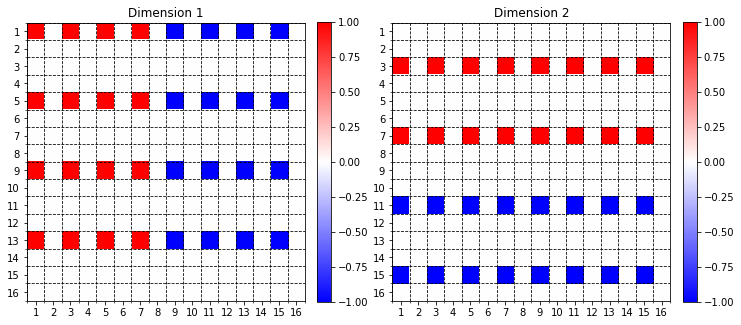

In [24]:
# your code here
tap_matrix1 = tp_mat_2d(width, height)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Dimension 1')
plot_tap_matrix(tap_matrix1[:,0], width, height)
plt.subplot(122)
plt.title('Dimension 2')
plot_tap_matrix(tap_matrix1[:,1], width, height)

### 2.2.2 Random approach
Now, for the baseline, complete the function `tp_mat_random()` to generate a $D$-dimensional random tap-point matrix. Later, you will compare your structured placement algorithm (from 2.2.1) against this algorithm (with $D = 2$). 

Keep in mind that Braindrop expects each dimension to have an even number of tap-points, as well as an equal number of $+1$'s and $-1$'s. That may be accomplished by creating a random ranking of the tap points and looping through this ranking, assigning $\{+\mathbf{e}_1, -\mathbf{e}_1, +\mathbf{e}_2, -\mathbf{e}_2, ..., +\mathbf{e}_D, -\mathbf{e}_D\}$, and repeating until the last tap-point is assigned an anchor-encoding vecot.

After writing the function, call it with the same array parameters (as in 2.1.1) and plot both dimensions of the anchor encoders.

In [12]:
def tp_mat_random(Din, width, height, rho=0):
    '''
    Creates a random 2D tap-point matrix
    
    Parameters
    ----------
    Din: int
        Dimensionality
    width: int
        Width of neuron array
    height: int
        Height of neuron array
    rho: int
        1/2**rho is the fraction of synaptic filters to use
    
    Returns
    -------
    tap_matrix: numpy matrix
        width*height x 2 tap-point matrix
    '''
    # your code here
    N = width*height
    tap_matrix = np.zeros((N, Din))
    
    total_taps = int(N/(4*4**rho))
    n_dims = np.random.permutation([len(dim_split) 
                                    for dim_split in np.array_split(range(total_taps // 2), Din)]).astype(int)
    random_order = []
    signs = []
    for half_ct, dim  in zip(n_dims, range(Din)):
        random_order.extend(int(2*half_ct)*[dim])
        signs.extend(half_ct*[-1,1])
    random_order = np.array([random_order, signs])
    
    perm = np.random.permutation(np.arange(total_taps))
    random_order = random_order[:, perm]
    
    I = np.eye(Din)
    
    count = 0
    for x in range(0, width, 2 * 2**rho):
        for y in range(0, height, 2 * 2**rho):
            tx = 2*np.random.randint(0, rho+1)
            ty = 2*np.random.randint(0, rho+1)
            n = (y +ty) * width + (x + tx)
            
            dim = random_order[0, count]
            sgn = random_order[1, count]
            tap_matrix[n, :] = sgn * I[dim, :]

            count += 1
            
    return tap_matrix

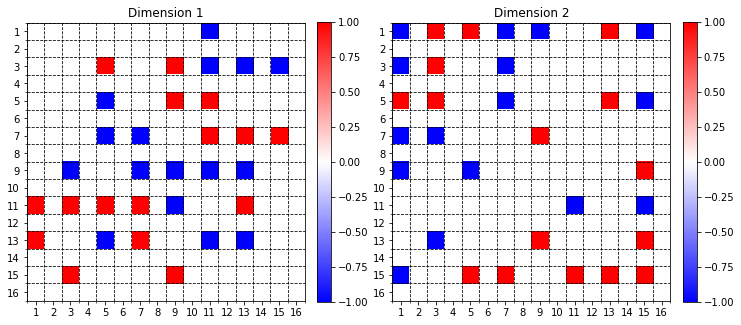

In [22]:
tap_matrix2 = tp_mat_random(2, width, height, 0)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Dimension 1')
plot_tap_matrix(tap_matrix2[:,0], width, height)
plt.subplot(122)
plt.title('Dimension 2')
plot_tap_matrix(tap_matrix2[:,1], width, height)


## 2.3 Visualizing Encoders
Having defined tap-point matrices, we would like to know the resulting encoders. To find out, we use the fact that a neuron's firing-rate increases most rapidly along the direction of its encoding vector. That enables us to estimate our pool's encoders from its neurons' measured tuning-curve by computing the $D$-dimensional gradient. This vector, when normalized, yields the encoder.

In this part of the problem, you will carry out this procedure for a 2D pool and produce a scatter plot of estimated encoding vectors.

### 2.3.1 Measuring tuning curves
The first step in this process is to collect tuning-curves. Follow a procedure similar to what the PyStorm walkthrough describes (Section 4). Build a PyStorm network, create a tap-point matrix, and initialize a pool, with parameters given below. Then, drive the input node with `make_cons_stimulus()` and create timestamps (in nanoseconds). Calling `run_and_sweep()` will return `(spike_obj, spike_bin_times)`, which can then be parsed with `data_utils.bins_to_rates(spike_obj[pool], spike_bin_times, times_w_end, init_discard_frac=.2)` to get a noisy estimate of the $Q^2$-by-$N$ tuning-curve matrix. To get a robust estimate of a tuning-curve's gradient, use `scipy.ndimage.filters.gaussian_filter()` to smooth the firing rate with width `tc_sigma`.

In [14]:
# pool parameters
width = 16
height = 16
N = width * height      # 256 neurons
Din = 2
Dout = 1

# tap-point density parameter
rho = 0

# number of samples per dimension
Q = 10

# training hold time
training_hold_time = 0.3

# smoothing width
tc_sigma = 1

# your code here

# creating the network
tap_matrix = tp_mat_2d(width, height, rho=rho)
net = graph.Network("net")
i1 = net.create_input("i1", Din)
p1 = net.create_pool("p1", tap_matrix, biases=3)
net.create_connection("c_i1_to_p1", i1, p1, None)
HAL.map(net)

# creating the stimulus
inp_times, inputs_const = make_cons_stimulus(Din, training_hold_time, Q)
FUDGE = 2
curr_time = HAL.get_time()
times = curr_time + FUDGE * 1e9 + inp_times * 1e9
times_w_end = np.hstack((times, times[-1] + training_hold_time * 1e9))
input_vals = {i1 : (times, inputs_const)}

# measuring spikes
rc = RunControl(HAL, net)
print("getting spikes")
_, spikes_and_bin_times = rc.run_input_sweep(input_vals, get_raw_spikes=True, 
                                             end_time=times_w_end[-1], rel_time=False)
spike_obj, spike_bin_times = spikes_and_bin_times
spike_ct = spike_obj[p1]

# building tuning-curve matrix
A_noisy = data_utils.bins_to_rates(spike_ct, spike_bin_times, times_w_end, init_discard_frac=.2)
A = np.zeros_like(A_noisy)
for n in range(N):
    A[:,n] = scipy.ndimage.filters.gaussian_filter(A_noisy[:,n], sigma=tc_sigma)


getting spikes


### 2.3.2 Estimating encoders
You're ready to estimate the pool's encoding vectors from your measured tuning curves by completing the function `estimate_encoders()` below. 

Reshape each of the $Q^2$-by-$N$ measurement matrix's $N$ columns into a $Q$-by-$Q$ matrix. For a general $D$-dimensional encoder, the matrix should have $D$ indices, each iterating from 1 to $Q$. This reshaped format makes estimating the tuning-curve's $D$-dimensional gradient easier. One way to do that is to take the average of `np.diff()` along each of its $D$ dimensions. That yields noisy scaled versions of the true derivative along each dimension. Take the average along each dimension to filter the noise and normalize to obtain a unit-length encoding vector. 

To check how reliable your $D$-dimensional gradient estimates are, compute SNR of their components from the finite differences' mean and standard deviation. If any component's SNR is less than some threshold, assign that neuron's encoding-vetor to be `np.nan`. In addition to the estimated encoding vectors, this function should return a list of neurons (indices) with valid encoding vectors.

After writing the function, call it on the measured tuning-curves and scatter-plot the result with a 1:1 aspect ratio (as in 2.1.1).

In [15]:
def estimate_encoders(A, Q, Din, snr_thresh=0.2):
    '''
    Estimates encoders for all tuning curves in matrix A
    
    Parameters
    ----------
    A: numpy matrix
        Tuning curve matrix with shape Q**Din -by- N
    Q: int
        Number of samples per dimensions
    Din: int
        Number of dimensions
    snr_thresh: float
        SNR threshold for gradient measurement. Gradients with lower SNR
        should set the associated encoder to NaN.
    Returns
    -------
    encoders: numpy matrix
        N-by-Din matrix of encoding vectors
    valid_enc_idx: Python list
        List of neuron indices for neurons with valid encoders (i.e., encoder is not nan)
    '''
    # your code here
    N = A.shape[1]
    encoders = np.zeros((N, Din))
    snrs = np.zeros((N,))
    valid_enc_idx = []
    for n in range(N):
        f = A[:,n]
        img = f.reshape(*[Q for j in range(Din)])
        diffs = [np.diff(img, axis=i) for i in range(Din)]
        snrs[n] = sum(np.abs(d.mean()) / d.std() for d in diffs) / Din
        if snrs[n] > snr_thresh:
            grad = [np.mean(np.diff(img, axis=i)) for i in range(Din)]
            grad = grad / np.linalg.norm(grad)
            valid_enc_idx.append(n)
        else:
            grad = np.array(Din*[np.nan])

        if Din > 1:
            grad[[0,1]] = grad[[1,0]]   # these get swapped by the transpose
        encoders[n] = grad
            
    return encoders, valid_enc_idx, snrs

Text(0,0.5,'$x_2$')

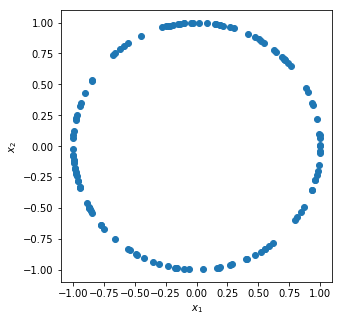

In [21]:
# your code here
encoders = estimate_encoders(A, Q, Din)[0]

plt.figure(figsize=(5,5))
plt.scatter(encoders[:,0], encoders[:,1]); ax = plt.gca()
plt.ylim([-1.1, 1.1])
plt.xlim([-1.1, 1.1])
ax.set_aspect('equal')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

## 2.4 Testing with the product function
In 2.1, we demonstrated how essential mixed-dimension encoders are for computing $f(\mathbf{x}) = x_1x_2$. Now use this function to test your tap-point placement algorithm's efficacy with Nengo-Brainstorm. Do so by calling `nengo_brainstorm.add_params(model)` with your Nengo model to create the dictionary `model.config` that will store all your pool-specific parameters. The following sections detail this process.

### 2.4.1 Create the base Nengo model
Since Nengo-Brainstorm emulates Nengo's structure and objects, first create a standard Nengo network (similar to 2.1). Use the same input $\mathbf{x}(t)$ (as in 2.1), a single 2D ensemble `ens`, and a single output node with `size_in=1` for this network. Connect the input to `ens` through synapses with the time-constant `tau_syn` and connect `ens` to the output with function `lambda x: x[0]*x[1]`. Finally, probe the input with time-constant `tau_syn` to model the ensemble's synapses, and probe the output with time-constant `tau_probe` to smooth the decoded spike-train.

In [41]:
# ensemble parameters
width = 16
heigh = 16
N = width * height
Din = 2
rho = 0

# synapse's time-constant
tau_syn = 0.02

# probe's time-constant
tau_probe = 0.05

# your code here
model = nengo.Network()

with model:
    inp_node = nengo.Node(lambda t: (np.cos(np.pi*t)/np.sqrt(2), np.sin(np.pi*t)/np.sqrt(2)))
    ens = nengo.Ensemble(N, dimensions=Din)
    out_node = nengo.Node(size_in=1)
    
    nengo.Connection(inp_node, ens, synapse=tau_syn)
    nengo.Connection(ens, out_node, function=lambda x: x[0]*x[1])
    
    inp_probe = nengo.Probe(inp_node, synapse=tau_syn)
    out_probe = nengo.Probe(out_node, synapse=tau_probe)

### 2.4.2 Configure parameters and simulate with random anchor-encoders
Now that you've set up the base Nengo model, you will now configure its pool's parameters. To do this, call `nengo_brainstorm.add_params(model)` to create the dictionary `model.config`. Use this dictionary to specify additional settings for `model`'s pools (Nengo-Brainstorm instantiates PyStorm objects under-the-hood). First, set the ensemble's width and height via `model.config[ens].width = width` and `model.config[ens].height = height`. Then, use `tp_mat_random()` to create a random 2D tap-point matrix and set `model.config[ens].tap_matrix` equal to it. 

Finally, set up spike-train filters for computing optimal decoders. Recall from the PyStorm walkthrough (Section 3) that we must filter the stimulus by the pool's synapses, apply the desired function, and then filter the result by the next stage's synapses. As we have just a single layer here, set `model.config[ens].training_input_filter` equal to the ensemble's synaptic time-constant `tau_syn` and `model.config[ens].training_output_filter` equal to the probe's time-constant `tau_probe`.

Once these configuration parameters have been set, create your Nengo-Brainstorm Simulator object (with `precompute_inputs=True` to speed up the simulation) and run it for a duration of $T = 4$ seconds. Store the simulation data from the output's probe and `sim.trange()` in their own variables.

In [45]:
# simulation length
T = 4

# your code here
nengo_brainstorm.add_params(model)

model.config[ens].width = width
model.config[ens].height = height
tap_mat_random = tp_mat_random(Din, width, height, rho=rho)
model.config[ens].tap_matrix = tap_mat_random
model.config[ens].training_input_filter = tau_syn
model.config[ens].training_output_filter = tau_probe

sim = nengo_brainstorm.Simulator(model, precompute_inputs=True)
sim.run(T)

random_tp_times = sim.trange()
random_tp_decode = sim.data[out_probe]

### 2.4.3 Redo the simulation with structured anchor encoders
You will now redo this simulation using a structured tap-point matrix. To compare tap-point matrices fairly, use the same pool of neurons on Braindrop. Call `tp_mat_2d()` to generate a structured 2-D tap-point matrix and assign it to `model.config[ens].tap_matrix`. Then re-initialize a Nengo-Brainstorm Simulator, run it for $T = 4$ seconds, and store the simulation data from the output's probe and `sim.trange()` in their own variables.

In addition, store the simulation data from the input's probe. You will use it to compute the target function and each decode's RMSEs.

In [46]:
# your code here
tap_mat_struct = tp_mat_2d(width, height, rho=rho)
model.config[ens].tap_matrix = tap_mat_struct
sim = nengo_brainstorm.Simulator(model, precompute_inputs=True)
sim.run(T)

struct_tp_times = sim.trange()
struct_tp_decode = sim.data[out_probe]
input_stim = sim.data[inp_probe]

/home/ee207student/anaconda3/lib/python3.6/site-packages/nengo_brainstorm/normal_form.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return func(x[[indices]])


Building finished in 0:00:01.                                                                                                               
Building finished in 0:00:01.                                                                                                               
Simulating finished in 0:00:01.                                                                                                             
Simulating finished in 0:00:01.                                                                                                             


### 2.4.4 Plot decodes and compare RMSEs
You will now solve for decoders and assess their performance. As the (probed) stimulus has already been filtered by the synaptic time-constant `tau_syn`, directly apply the function $f(\mathbf{x}(t)) = x_1(t)x_2(t)$ to it. Filter the result with `nengo.synapses.Lowpass(tau_probe)` to align it with the filtered spike-trains from Braindrop. This procedure mirrors that in the PyStorm walkthrough (Section 3).

 - Plot the decodes obtained with random and structured tap-point matrices vs. time $t$. 
  - Overlay them on the target function (computed with the procedure above). 
  - Include legends and axes labels.
 - Print the decodes' RMSE to quantify the structured and random tap-point matrix's performance.

RMSE from Random TP Matrix: 0.2952571125779365
RMSE from Structured TP Matrix: 0.24945290806352907


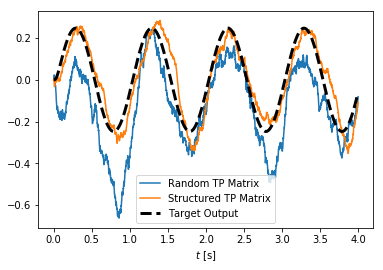

In [54]:
# your code here
probe = nengo.synapses.Lowpass(tau_probe)
des_out = probe.filt(np.array([x*y for x,y in sim.data[inp_probe]]), y0=0, dt=1e-3)

plt.figure()
plt.plot(random_tp_times, random_tp_decode, label='Random TP Matrix')
plt.plot(struct_tp_times, struct_tp_decode, label='Structured TP Matrix')
plt.plot(struct_tp_times, des_out, '--k', label='Target Output', lw=3)
plt.xlabel(r'$t$ [s]')
plt.legend()

print("RMSE from Random TP Matrix:", np.sqrt(np.mean((des_out - random_tp_decode)**2)))
print("RMSE from Structured TP Matrix:", np.sqrt(np.mean((des_out - struct_tp_decode)**2)))

## 2.5 Create a 3+ Dimensional Tap-Point Matrix

In 2.2, you wrote a function that creates 2-D tap-point matrices. As $D$ increases, hyperquadrants grow exponentially (as $2^D$). Spanning each one requires interpolating between $D$ standard-basis vectors $\mathbf{e}_d \in \{-1,0,+1\}^D$, $d = 1,...,D$. Thus, anchor encoding-vectors must be assigned to tap-points on a grid of $D$-sided polygons, such that these polygons share the same anchor encoders where they touch. That makes mapping a $D$-dimensional sphere onto a 2D diffuser more challenging as $D$ increases.

The placement algorithm currently used for higher dimensions is heuristic. It simply chooses anchor encoders orthogonal to their neighbors; the number of tap-points per dimension grows with $D$. While conceptually simple, its implementation is moderately involved. To help, we've broken it into these two functions: 
 - `get_anchors()` finds candidates for a given location's anchor-encoding vector.
 - `nD_tp_matrix()` iterates over valid tap-points and assigns anchor encoders. 
 
Below, you'll start with the former.

### 2.5.1 Find an orthogonal anchor encoder
In order to choose a new anchor encoder orthogonal to its neighbors, we build a list of neighbors with `get_neighbor_encoders()`. It takes a position `(x,y)` and a matrix of anchor encoders already assigned to tap-points `vects`. It returns anchor encoders of `(x,y)`'s already-assigned neighbors. Although position `(x,y)` can have up to 8 neighbors, only 4 have anchor encoders already assigned because assignments are made by raster-scanning through tap-points. Since a $D$-dimensional unit-vector has only $D-1$ mutually-orthogonal unit-vectors, `get_neighbor_encoders()` returns a list of 2 or 3 candidates for anchor encoders when $D = 3$ or $D = 4$, respectively. For $D\geq 5$, it returns a list of 4 candidates.

For $D=3$, `(x,y)`'s two neighbors are to the left and above. For $D=4$, the above-left tap-point is added. For $D\geq 5$, the addition depends on how the 2-D diffuser is traversed (`assign_dir`). If it's left-to-right and then top-to-bottom (`assign_dir="LR"`), then the above-right tap-point is added. If it's top-to-bottom and then left-to-right (`assign_dir="TB"`), then the below-left tap-point is added. If $D>5$, no tap-point is added because all the already-assigned neighbors have been exhausted.

In [8]:
def get_neighbor_encoders(x, y, vects, assign_dir):
    '''
    Gets the anchor encoders of the neighbors to the point (x, y)
    
    Parameters
    ----------
    x: int
        Current position along the width axis
    y: int
        Current position along the height axis
    vects: numpy matrix
        X-by-Y-by-D matrix of current tap point anchor encoders.
        This will fill up completely with nonzero-vectors as the
        algorithm proceeds.
    assign_dir: string
        Either "LR" or "TB" for the direction in which we are assigning
        tap-points (and thus which neighbors to consider). "LR" means we scan
        left-to-right before moving down the height axis of the tap-point matrix.
        "TB" means we scan top-to-bottom before moving right across the width axis.
        This only changes the neighbor in the 5+ dimensional case.
    
    Returns
    -------
    elim_vects: Python List
        List of length-D numpy arrays corresponding to anchor encoders of 
        the current position's neighbors
    '''
    # your code here
    X, Y, D = vects.shape
    
    elim_vects = []
    if assign_dir == "LR":
        if D >= 3:
            if x > 0:
                elim_vects.append(vects[x-1, y, :])
            if y > 0:
                elim_vects.append(vects[x, y-1, :])
        if D >= 4:
            if x > 0 and y > 0:
                elim_vects.append(vects[x-1, y-1, :])
        if D >= 5:
            if x < X and y > 0:
                elim_vects.append(vects[x+1, y-1, :])
                
    elif assign_dir == "TD":
        if D >= 3:
            if y > 0:
                elim_vects.append(vects[x, y-1, :])
            if x > 0:
                elim_vects.append(vects[x-1, y, :])
        if D >= 4:
            if x > 0 and y > 0:
                elim_vects.append(vects[x-1, y-1, :])
        if D >= 5:
            if y < Y and x > 0:
                elim_vects.append(vects[x-1, y+1, :])
    return elim_vects


### 2.5.2 Select orthogonal vector
Now complete `get_orthogonal_vector()` to find an orthogonal anchor encoder. It takes a list of neighboring anchor encoders and returns a standard-basis vector orthogonal to this list, with random sign.

In [9]:
def get_orthogonal_vector(vect_list, D):
    '''
    Finds a cartesian basis vector which is orthogonal to 
    the basis vectors in the list.
    
    Parameters
    ----------
    vect_list: Python list of numpy arrays
        List of D-dimensional standard basis vectors. List has at most D-1 vectors.
    D: int
        Dimensionality of encoder space
    
    Returns
    -------
    orth_vect: numpy array
        Length-D array of one of the 2*D signed basis vectors
    '''
    # your code here
    if len(vect_list) > 0:
        dims_taken = np.abs(np.array(vect_list)).sum(axis=0)
        dims_valid = np.arange(D)[dims_taken == 0]
    else:
        dims_valid = np.arange(D)
    
    dims_valid = np.array(dims_valid)
    dim = np.random.choice(dims_valid)
    sign = 2*(np.random.rand() > 0.5) - 1
    
    ortho_vect = np.zeros((D,))
    ortho_vect[dim] = sign
    return ortho_vect


### 2.5.3 Assign anchor-encoding vectors to tap-points
With these two helper functions complete, you're ready to write `get_anchors()`. This function takes tap-points-along-width `X`, tap-points-along-height `Y`, and dimensionality `D`. It returns a `X`-by-`Y`-by-`D` matrix `vects` of anchor-encoding vectors. 

To do so, it traverses the `X`-by-`Y` space, determines the anchor encoders neighboring its current location `(x,y)`, and finds an orthogonal anchor encoder $\mathbf{e}_{(x,y)}$, choosing its sign randomly. To ensure each dimension's $\pm 1$ tap-points are balanced, each traversal must place both $\mathbf{e}_{(i,j)}$ and its oppositely-signed encoder $-\mathbf{e}_{(x,y)}$. Place the oppositely-signed encoder at $(x',y') = (X-x, Y-y)$. This choice guarantees its orthogonal to its own neighbors by running two parallel but coupled assignment procedures over the full `X`-`Y` space. Thus, set the limits of your nested for-loops to half of the full `X`-`Y` space. 

Finally, decide the order in which to visit these locations $(x,y)$. A good solution is to scan left-to-right and top-to-bottom when `Y > X`, and to scan top-to-bottom and left-to-right when `X > Y`. Either is appropriate when `X == Y`. The reason for taking this approach is that it minimizes the number of tap-points at the interface between the two parallel assignment procedures, and so minimizes the number of adjacent tap-points with non-orthogonal anchor encoders. 

In [10]:
def get_anchors(X, Y, D):
    '''
    Get D-dimensional anchor encoders for all pairs in X x Y
    
    Parameters
    ----------
    X: int
        Number of valid tap points along width axis
    Y: int
        Number of valid tap points along height axis
    D: int
        Dimensionality of encoding space (D > 3)
    
    Returns
    -------
    vects: numpy matrix
        X-by-Y-by-D matrix of anchor encoders for each (x,y) entry
    '''
    # your code here
    vects = np.zeros((X, Y, D))
    ct = 0
    
    if X >= Y:
        raster_dir = "TB"
        Xmax = int(X/2)
        for x in range(Xmax):
            for y in range(Y):
                
                elim_vects = get_neighbor_encoders(x, y, vects, raster_dir)
                ortho_vect = get_orthogonal_vector(elim_vects, D)
                vects[x, y, :] = ortho_vect
                vects[X-x-1, Y-y-1, :] = -ortho_vect
        
    else:
        raster_dir = "LR"
        Ymax = int(Y/2)
        for y in range(Ymax):
            for x in range(X):

                elim_vects = get_neighbor_encoders(x, y, vects, raster_dir)
                ortho_vect = get_orthogonal_vector(elim_vects, D)
                vects[x, y, :] = ortho_vect
                vects[X-x-1, Y-y-1, :] = -ortho_vect

    return vects

### 2.5.4 Build tap-point matrix
You're now finally ready to put all the pieces together to create a $N$-by-$D$ tap-point matrix. Complete `nD_tp_matrix()`. It takes dimensions $D$, pool width $W$ and height $H$, and (optional) density parameter $\rho$, which sets the fraction of synaptic filters used to $1/2^\rho$. Naturally, it returns a $N$-by-$D$ tap-point matrix.

To do this, call `get_anchors()` to get an ordered matrix of anchor encoders, then loop over tap-points (as in the 1D and 2D case) and assign them encoding vectors.

Call this function for $D = 3$ and $D = 4$ and plot all the anchor-encoders' dimensions with `plot_tap_matrix()`.

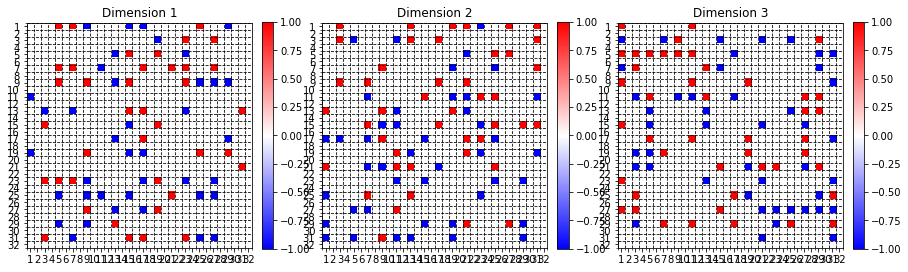

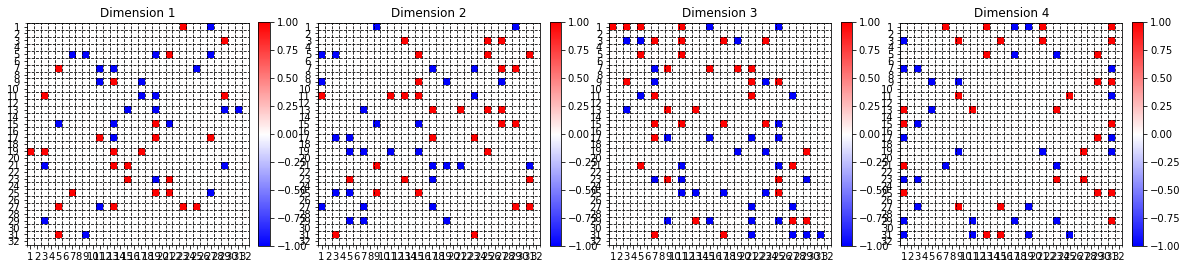

In [11]:
# pool parameters
width = 32
height = 32
width_height = (width, height)
N = width * height      # 256 neurons
Din = 2
Dout = 1


def nD_tp_matrix(D, width, height, rho=0):
    '''
    Creates tap-point matrix for D-dimensional encoders
    
    Parameters
    ----------
    D: int
        Dimensionality of encoding space (D > 3)
    width: int
        Width of neuron array
    height: int
        Height of neuron array
    rho: int
        1/2**rho is the fraction of total tap-points the 
        algorithm should use
    
    Returns
    -------
    tap_matrix: numpy matrix
        width*height x D tap-point matrix
    '''
    N = width*height
    X = int(width/(2 * 2**rho))
    Y = int(height/(2 * 2**rho))
    anchors = get_anchors(X, Y, D)
    
    tap_matrix = np.zeros((N, D))
    xl = list(range(2**rho - 1, width, 2 * 2**rho))
    yl = list(range(2**rho - 1, height, 2 * 2**rho))
    for ix, x in enumerate(xl):
        for iy, y in enumerate(yl):
            n = y * width + x
            tap_matrix[n, :] = anchors[ix, iy, :]
    
    return tap_matrix

tap3 = nD_tp_matrix(3, width, height)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Dimension 1')
plot_tap_matrix(tap3[:,0], width, height)
plt.subplot(132)
plt.title('Dimension 2')
plot_tap_matrix(tap3[:,1], width, height)
plt.subplot(133)
plt.title('Dimension 3')
plot_tap_matrix(tap3[:,2], width, height)

tap4 = nD_tp_matrix(4, width, height)
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.title('Dimension 1')
plot_tap_matrix(tap4[:,0], width, height)
plt.subplot(142)
plt.title('Dimension 2')
plot_tap_matrix(tap4[:,1], width, height)
plt.subplot(143)
plt.title('Dimension 3')
plot_tap_matrix(tap4[:,2], width, height)
plt.subplot(144)
plt.title('Dimension 4')
plot_tap_matrix(tap4[:,3], width, height)

## 2.6 Test with Product Functions
As in 2.1 and 2.4, you will use $f(\mathbf{x}) = \Pi_i^D x_i$ to test how uniformly the diffuser interpolates the anchor encoders well your algorithm placed across the $D$-dimensional hypersphere.  For both $D=3$ and $D=4$, compare your results to random placement using `tp_mat_random()` (from 2.2.2). The procedures Nengo-Brainstorm  performs when it builds a Simulator object can take quite long for high dimensions. It's faster to build and test your model directly with PyStorm. We've supplied the following functions to simplify this task:
 - `collect_training_spikes()` time-stamps a $D$-dimensional stimulus and sends it through `input_node`. It then collects spikes from `pool` and returns them along with simulation data.
 - `compute_decoders()` filters the spikes with `tau_syn_out`, to build a measurement matrix $\mathbf{A}$; filters the stimulus with `tau_syn_in`, applying the function `func`; and filters the result with `tau_syn_out`, to get the target output $\mathbf{f}$. It returns the decoders, $\mathbf{A}$, $\mathrm{f}$, and a potentially rescaled $f_\mathrm{max}$.

In [12]:
def collect_training_spikes(HAL, net, inp_times, inp_stim, input_node, pool):
    FUDGE = 2
    curr_time = HAL.get_time()
    times = curr_time + FUDGE * 1e9 + inp_times * 1e9
    times_w_end = np.hstack((times, times[-1] + input_dt * 1e9))
    input_vals = {input_node : (times, inp_stim)}
    rc = RunControl(HAL, net)
    print("getting spikes")
    _, spikes_and_bin_times = rc.run_input_sweep(input_vals, get_raw_spikes=True, 
                                                 end_time=times_w_end[-1], rel_time=False)
    print("done")
    spike_dict, spike_bin_times = spikes_and_bin_times
    spike_ct = spike_dict[pool]
    spikes = spike_ct / input_dt
    inp_times_trunc = inp_times[:spikes.shape[0]]
    inp_stim_trunc = inp_stim[:spikes.shape[0],:]
    
    return spikes, inp_times_trunc, inp_stim_trunc

def compute_decoders(tau_syn_in, tau_syn_out, spikes, inp_stim, func, fmax):
    syn_in = nengo.synapses.Lowpass(tau_syn_in)
    syn_out = nengo.synapses.Lowpass(tau_syn_out)

    A = syn_out.filt(spikes, y0=0, dt=input_dt)
    xin = syn_in.filt(inp_stim, y0=0, dt=input_dt)
    fx = np.array([func(xi) for xi in xin])
    f = syn_out.filt(fx, y0=0, dt=input_dt)
    
    solver = nengo.solvers.LstsqL2(reg=0.0001)
    decoders, _ = solver(A, f)
    max_d = np.max(np.abs(decoders))
    if max_d > 1:
        fmax_out = fmax / max_d
        decoders /= max_d
        print("rescaling by", max_d)
    else:
        fmax_out = fmax
    
    return decoders, A, f, fmax_out


### 2.6.1 3-D encoders and $f(\mathbf{x}) = x_1x_2x_3$
Compare your placement algorithm to a random placement for $D = 3$ using a 32-by-32 neuron pool and $\rho = 1$. Construct two simple encoder-decoder networks `net_struct` and `net_random` (as in section 1.2 of the PyStorm walkthrough) with `Din=3`, a synaptic time-constant `tau_syn=0.02`, and a probe time-constant `tau_probe=0.05`. For `net_struct`, use `nD_tp_matrix()` to create a structured 3-D tap-point matrix. For `net_random`, use `tp_mat_random()` to create a random 3-D tap-point matrix. Connect nodes, pool, and bucket, with initial decode weights of 0. Use `make_sine_stimulus()` to train both networks, with a $2\pi\tau_s$ base period, $4(Q/2)^D$ cycles, and $Q = 10$.

After calling `HAL.map()`, drive both networks with your stimulus and collect their neurons' spikes using `collect_training_spikes()` (defined above). Compute optimal decoders for $f(\mathbf{x}) = x_1x_2x_3$ using `compute_decoders()`. Pass it your synapse's and probe's time-constants. Do this for both networks.
 - Plot both decode's first two seconds and the desired output vs. time $t$. Include a legend and label axes.
 - Print both decode's RMSE, normalized by the the desired function's peak-to-peak range.

In [13]:
# run this code to set time resolutions on Braindrop (downstream) and the host (upstream)
downstream_time_res = 10000 # ns, or 10us
upstream_time_res = 1000000 # ns, or 1ms

HAL.set_time_resolution(downstream_time_res, upstream_time_res)

calling map
getting spikes
done
calling map
getting spikes
done
rescaling by 1.2712786246127872
Normalized RMSE from Structured TP Matrix: 0.08918726288414479
Normalized RMSE from Random TP Matrix: 0.0968502349907097


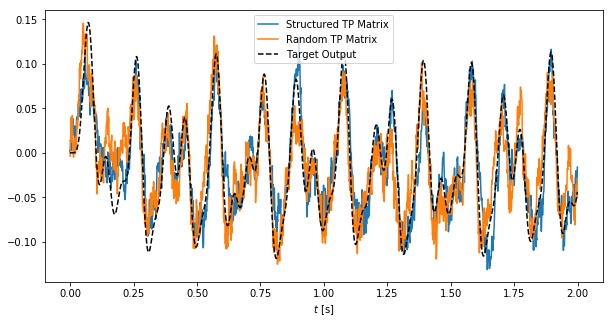

In [14]:
# your code here
width = 32
heigh = 32
N = width * height
Din = 3
Dout = 1
rho = 1
tau_syn = 0.02
tau_probe = 0.05
decoders1 = np.zeros((Dout, N))
decoders2 = np.zeros((Dout, N))
tap3 = nD_tp_matrix(Din, width, height, rho=rho)
tap3rand = tp_mat_random(Din, width, height, rho=rho)

# network with structured tap-point matrix
net1 = graph.Network("net1")
i1 = net1.create_input("i1", Din)
p1 = net1.create_pool("p1", tap3)
b1 = net1.create_bucket("b1", Dout)
o1 = net1.create_output("o1", Dout)
net1.create_connection("c_i1_to_p1", i1, p1, None)
decoder_conn = net1.create_connection("c_p1_to_b1", p1, b1, decoders1)
net1.create_connection("c_b1_to_o1", b1, o1, None)

# network with random tap-point matrix
net2 = graph.Network("net2")
i2 = net2.create_input("i2", Din)
p2 = net2.create_pool("p2", tap3rand)
b2 = net2.create_bucket("b2", Dout)
o2 = net2.create_output("o2", Dout)
net2.create_connection("c_i2_to_p2", i2, p2, None)
decoder_conn = net2.create_connection("c_p2_to_b2", p2, b2, decoders2)
net2.create_connection("c_b2_to_o2", b2, o2, None)

# same stimulus for both networks
fmax = 1000
input_dt = 1e-3
base_period = 2*np.pi*tau_syn # approximately 125 ms
Q = 10
cycles = 4* ((Q / 2)**Din)
inp_times, inputs_sin = make_sine_stimulus(Din, base_period, cycles, fmax=fmax, input_dt=input_dt)

# collect spikes from both networks
print("calling map")
HAL.map(net1)
spikes1, inp_times1, inputs_sin1 = collect_training_spikes(HAL, net1, inp_times, inputs_sin, i1, p1)
print("calling map")
HAL.map(net2)
spikes2, inp_times2, inputs_sin2 = collect_training_spikes(HAL, net2, inp_times, inputs_sin, i2, p2)

# compute optimal decoders for both networks
func = lambda x: x[0]*x[1]*x[2] / fmax**2
decoders1, A1, f1, fmax1_out = compute_decoders(tau_syn, tau_probe, spikes1, inputs_sin1, func, fmax)
decoders2, A2, f2, fmax2_out = compute_decoders(tau_syn, tau_probe, spikes2, inputs_sin2, func, fmax)

# compute decodes from both networks
fhat1 = A1 @ decoders1
fhat1_out = fhat1 / fmax1_out
f1_out = f1 / fmax
rmse1 = np.sqrt(np.mean((f1_out - fhat1_out)**2)) / (np.max(f1_out) - np.min(f1_out))

fhat2 = A2 @ decoders2
fhat2_out = fhat2 / fmax2_out
f2_out = f2 / fmax
rmse2 = np.sqrt(np.mean((f2_out - fhat2_out)**2)) / (np.max(f2_out) - np.min(f2_out))

print("Normalized RMSE from Structured TP Matrix:", rmse1)
print("Normalized RMSE from Random TP Matrix:", rmse2)

plt.figure(figsize=(10,5))
plt.plot(inp_times1[:int(2/input_dt)], fhat1_out[:int(2/input_dt)], label='Structured TP Matrix')
plt.plot(inp_times2[:int(2/input_dt)], fhat2_out[:int(2/input_dt)], label='Random TP Matrix')
plt.plot(inp_times1[:int(2/input_dt)], f1_out[:int(2/input_dt)], '--k', label='Target Output')
plt.xlabel(r'$t$ [s]')
plt.legend()


### 2.6.2 4-D encoders and $f(\mathbf{x}) = x_1x_2x_3x_4$
Compare your placement algorithm to a random placement for $D = 4$ using a 32-by-32 neuron pool and $\rho = 0$.  
 - Plot both decode's first two seconds and the desired output vs. time $t$. Include a legend and label axes.
 - Print both decode's RMSE, normalized by the the desired function's peak-to-peak range.

Normalized RMSE from Structured TP Matrix: 0.15784442413254157
Normalized RMSE from Random TP Matrix: 0.19021233149630984


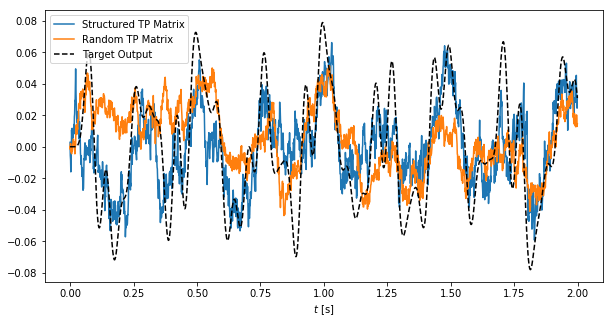

In [15]:
# your code here
width = 32
heigh = 32
N = width * height
Din = 4
Dout = 1
rho = 0
tau_syn = 0.02
tau_probe = 0.05
decoders1 = np.zeros((Dout, N))
decoders2 = np.zeros((Dout, N))
tap4 = nD_tp_matrix(Din, width, height, rho=rho)
tap4rand = tp_mat_random(Din, width, height, rho=rho)

# network with structured tap-point matrix
net1 = graph.Network("net1")
i1 = net1.create_input("i1", Din)
p1 = net1.create_pool("p1", tap4)
b1 = net1.create_bucket("b1", Dout)
o1 = net1.create_output("o1", Dout)
net1.create_connection("c_i1_to_p1", i1, p1, None)
decoder_conn = net1.create_connection("c_p1_to_b1", p1, b1, decoders1)
net1.create_connection("c_b1_to_o1", b1, o1, None)

# network with random tap-point matrix
net2 = graph.Network("net2")
i2 = net2.create_input("i2", Din)
p2 = net2.create_pool("p2", tap4rand)
b2 = net2.create_bucket("b2", Dout)
o2 = net2.create_output("o2", Dout)
net2.create_connection("c_i2_to_p2", i2, p2, None)
decoder_conn = net2.create_connection("c_p2_to_b2", p2, b2, decoders2)
net2.create_connection("c_b2_to_o2", b2, o2, None)

# same stimulus for both networks
fmax = 1000
input_dt = 1e-3
base_period = 2*np.pi*tau_syn # approximately 125 ms
Q = 10
cycles = 5* ((Q / 2)**Din)
inp_times, inputs_sin = make_sine_stimulus(Din, base_period, cycles, fmax=fmax, input_dt=input_dt)

# collect spikes from both networks
print("calling map")
HAL.map(net1)
spikes1, inp_times1, inputs_sin1 = collect_training_spikes(HAL, net1, inp_times, inputs_sin, i1, p1)
print("calling map")
HAL.map(net2)
spikes2, inp_times2, inputs_sin2 = collect_training_spikes(HAL, net2, inp_times, inputs_sin, i2, p2)

# compute optimal decoders for both networks
func = lambda x: x[0]*x[1]*x[2]*x[3] / fmax**3
decoders1, A1, f1, fmax1_out = compute_decoders(tau_syn, tau_probe, spikes1, inputs_sin1, func, fmax)
decoders2, A2, f2, fmax2_out = compute_decoders(tau_syn, tau_probe, spikes2, inputs_sin2, func, fmax)

# compute decodes from both networks
fhat1 = A1 @ decoders1
fhat1_out = fhat1 / fmax1_out
f1_out = f1 / fmax
rmse1 = np.sqrt(np.mean((f1_out - fhat1_out)**2)) / (np.max(f1_out) - np.min(f1_out))

fhat2 = A2 @ decoders2
fhat2_out = fhat2 / fmax2_out
f2_out = f2 / fmax
rmse2 = np.sqrt(np.mean((f2_out - fhat2_out)**2)) / (np.max(f2_out) - np.min(f2_out))

print("Normalized RMSE from Structured TP Matrix:", rmse1)
print("Normalized RMSE from Random TP Matrix:", rmse2)

plt.figure(figsize=(10,5))
plt.plot(inp_times1[:int(2/input_dt)], fhat1_out[:int(2/input_dt)], label='Structured TP Matrix')
plt.plot(inp_times2[:int(2/input_dt)], fhat2_out[:int(2/input_dt)], label='Random TP Matrix')
plt.plot(inp_times1[:int(2/input_dt)], f1_out[:int(2/input_dt)], '--k', label='Target Output')
plt.xlabel(r'$t$ [s]')
plt.legend()

